# BBC News classification

[BBC News Classification Dataset](https://www.kaggle.com/c/learn-ai-bbc/overview)

In [1]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
with open("./bbc-text.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

Each data point looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially

In [3]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [4]:
def remove_stopwords(sentence):
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [5]:
# Test the functions
sentences, labels = parse_data_from_file("./bbc-text.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 2225 sentences in the dataset.

First sentence has 436 words (after removing stopwords).

There are 2225 labels in the dataset.

The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']


In [21]:
print(labels[0])
print(sentences[0])


tech
tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv will radically different five years time. according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend programmes content will delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices. one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes like us s tivo uk s sky+ system allow people record store play pause forward wind tv programmes want. essentially technology allows much personalised tv. also built-in high-definition tv sets big business japan us slower take off europe lack high-definition programming. not can people forward wind adverts can also forget abiding network channel schedules putting together a-la-carte entertainment. us networks cable sa

In [22]:
def train_val_split(sentences, labels, training_split):
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences))

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:int(training_split*train_size)]
    train_labels = labels[:int(training_split*train_size)]

    validation_sentences = sentences[int(training_split*train_size):]
    validation_labels = labels[int(training_split*train_size):]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [8]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1780 sentences for training.

There are 1780 labels for training.

There are 445 sentences for validation.

There are 445 labels for validation.


In [23]:
def fit_tokenizer(train_sentences, num_words, oov_token):

    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [24]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 27285 words

<OOV> token included in vocabulary


In [25]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    
    return padded_sequences

In [26]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1780, 120)

Padded validation sequences have shape: (445, 120)


A couple of things to note:
- You should fit the tokenizer to all the labels to avoid the case of a particular label not being present in the validation set. Since you are dealing with labels there should never be an OOV label.


- In the previous function you used the `pad_sequences` function which returns numpy arrays. Here you will not be using it since you don't need to pad the labels so you need to make the conversion to numpy arrays yourself.


- The argument `split_labels` refers to the labels of a particular split (train or validation). This is because the function should work independently of the split being used.


- Using Keras' Tokenizer yields values that start at 1 rather than at 0. This will present a problem when training since Keras usually expects the labels to start at 0. To work around this issue you could use an extra neuron in the last layer of your model. However this approach is rather hacky and not very clear. Instead you will substract 1 from every value of the labels that the function returns. Remember that when using numpy arrays you can simply do something like `np.array - 1` to accomplish this since numpy allows for vectorized operations.

In [37]:
def tokenize_labels(all_labels, split_labels):
    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq) - 1
    
    return label_seq_np, label_tokenizer

In [38]:
# Test your function
train_label_seq, label_tokenizer = tokenize_labels(labels, train_labels)
val_label_seq, label_tokenizer = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[3]
 [1]
 [0]
 [0]
 [4]]

First 5 labels of the validation set should look like this:
[[4]
 [3]
 [2]
 [0]
 [0]]

Tokenized labels of the training set have shape: (1780, 1)

Tokenized labels of the validation set have shape: (445, 1)



In [28]:
def create_model(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        #tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        #tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model


In [29]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
56/56 [==============================] - 1s 4ms/step - loss: 1.6014 - accuracy: 0.2404 - val_loss: 1.5870 - val_accuracy: 0.4427
Epoch 2/30
56/56 [==============================] - 0s 2ms/step - loss: 1.5487 - accuracy: 0.4045 - val_loss: 1.4913 - val_accuracy: 0.4360
Epoch 3/30
56/56 [==============================] - 0s 2ms/step - loss: 1.3598 - accuracy: 0.5685 - val_loss: 1.2237 - val_accuracy: 0.6764
Epoch 4/30
56/56 [==============================] - 0s 2ms/step - loss: 1.0057 - accuracy: 0.7972 - val_loss: 0.8635 - val_accuracy: 0.8539
Epoch 5/30
56/56 [==============================] - 0s 2ms/step - loss: 0.6543 - accuracy: 0.9045 - val_loss: 0.5836 - val_accuracy: 0.8944
Epoch 6/30
56/56 [==============================] - 0s 2ms/step - loss: 0.4230 - accuracy: 0.9320 - val_loss: 0.4231 - val_accuracy: 0.9034
Epoch 7/30
56/56 [==============================] - 0s 2ms/step - loss: 0.2931 - accuracy: 0.9500 - val_loss: 0.3397 - val_accuracy: 0.9169
Epoch 8/30
56/56 [==

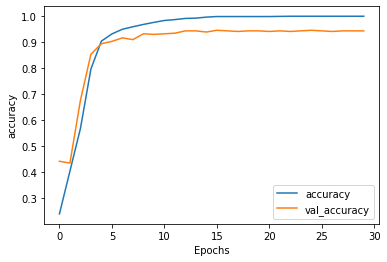

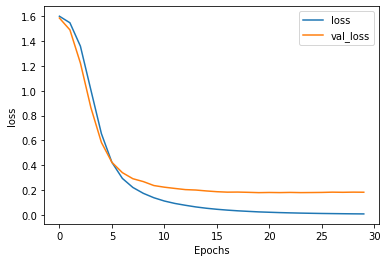

In [17]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [18]:
# Reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Save the embedding layer
e = model.layers[0]

# Save the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (1000, 16)


In [19]:
# Generate files for embedding visualization
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [51]:
news = ["Sri Lankan President Gotabaya Rajapaksa has announced he will step down after protesters stormed his official residence and set the prime minister's house on fire.\
        Hundreds of thousands descended on the capital Colombo, calling for Mr Rajapaksa to resign after months of protests over economic mismanagement. \
        One protester, Fiona Sirmana, who was demonstrating at the president's house, said it was time to get rid of the president and the prime minister and to have a new era for Sri Lanka. \
        Ranil Wickremesinghe's home was on fire on Saturday evening after protesters broke in and set it alight. Videos circulating on social media show flames lighting up the night sky."]
testing_padded = seq_and_pad(news, tokenizer, PADDING, MAXLEN)
tf.argmax(model.predict(testing_padded), axis = -1) + 1

1/1 [==============================] - 0s 14ms/step


<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>

In [52]:
label_tokenizer.index_word

{1: 'sport', 2: 'business', 3: 'politics', 4: 'tech', 5: 'entertainment'}

In [55]:
news = ["Elon Musk is seeking to end his $44bn (£36bn) bid to buy Twitter, alleging multiple breaches of the agreement. \
The announcement is the latest twist in a long-running saga after the world's richest person decided to buy Twitter in April. \
Mr Musk said he had backed out because Twitter failed to provide enough information on the number of spam and fake accounts. \
Twitter says it plans to pursue legal action to enforce the agreement. \
The Twitter Board is committed to closing the transaction on the price and terms agreed upon with Mr. Musk, Twitter chairman Bret Taylor wrote in a tweet, setting up a potentially long and protracted legal battle between the two sides. \
The original merger agreement includes a $1bn (£830m) break-up fee. \
In May, Mr Musk said the deal was temporarily on hold as he was awaiting data on the number of fake and spam accounts on Twitter. \
The billionaire businessman had asked for evidence to back the company's assertion that spam and bot accounts make up less than 5% of its total users. \
In a letter filed with the US Securities and Exchange Commission, Mr Musk's lawyer said Twitter had failed or refused to provide this information. \
Sometimes Twitter has ignored Mr. Musk's requests, sometimes it has rejected them for reasons that appear to be unjustified, and sometimes it has claimed to comply while giving Mr. Musk incomplete or unusable information, the letter reads. \
Spam accounts are designed to spread information to large numbers of people and manipulate the way they interact with the platform. On Thursday, Twitter said it removed around 1 million such accounts each day. \
Mr Musk believes that spam or bot accounts could account for 20% or more of Twitter users. \
Shares in Twitter fell by 7% in extended trading after the announcement."]
testing_padded = seq_and_pad(news, tokenizer, PADDING, MAXLEN)
tf.argmax(model.predict(testing_padded), axis = -1) + 1

1/1 [==============================] - 0s 15ms/step


<tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>